In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import xarray as xa

fdir = "/home/jungyoung/Project_win/hh_neuralnet/"

import hhclustering as hc
import utils 

from importlib import reload
reload(utils)

<module 'utils' from '/home/jungyoung/Project/hh_neuralnet/dynamics_clustering/utils.py'>

In [3]:
postdata = xa.open_dataarray("../three_pop_mpi/simulation_data/postdata.nc")

print(postdata.attrs["date"])
# coordiinate of postdata
postdata.coords

2023-9-21


Coordinates:
  * key      (key) object 'chi' 'cv' 'frs_m' ... 'leading_ratio(abs)' 'dphi'
  * alpha    (alpha) float64 0.0 0.1429 0.2857 0.4286 ... 1.571 1.714 1.857 2.0
  * beta     (beta) float64 0.0 0.07143 0.1429 0.2143 ... 0.8571 0.9286 1.0
  * w        (w) float64 0.1 0.25 0.4 0.55 0.7 0.85 1.0
  * pop      (pop) object 'T' 'F' 'S'
  * rank     (rank) float64 0.0 0.5 1.0
  * type     (type) object 'mean' 'var'

In [4]:
## Extract row and column informatio

# Extract row
num_row = 0
index_row = []
for k in postdata.coords["key"].data:
    if "_ft" in k:
        continue

    if "leading_ratio" in k:
        num_row += 1
        index_row.append(dict(key=k, pop=["F"], type=["mean"]))
    elif "cc" in k or "dphi" in k:
        num_row += len(postdata.coords["type"])
        index_row.append(dict(key=k, pop=["S"], type=["mean", "var"]))
    else:
        num_row += len(postdata.coords["type"]) * len(postdata.coords["pop"])
        index_row.append(dict(key=k, pop=["T", "F", "S"], type=["mean", "var"]))
    
# Extract column
num_col = len(postdata.coords["alpha"]) * len(postdata.coords["beta"]) * len(postdata.coords["w"]) * len(postdata.coords["rank"])
index_col = []
for a in postdata.coords["alpha"].data:
    for b in postdata.coords["beta"].data:
        for w in postdata.coords["w"].data:
            for r in postdata.coords["rank"].data:
                index_col.append(dict(alpha=a, beta=b, w=w, rank=r))
                
print(num_row, num_col)

50 4725


In [19]:
## align data

scaling = False # min-max scaling

row_names = []
pop_types = []
data = np.zeros([num_row, num_col])

nid = 0
for nr in range(len(index_row)):
    key = index_row[nr]["key"]
    for pop in index_row[nr]["pop"]:
        for tp in index_row[nr]["type"]:
            
            # read data
            data[nid, :] = postdata.sel(dict(key=key, pop=pop, type=tp)).data.flatten()
            
            if tp == "var":
                var_data = data[nid, :]
                if any(var_data < 0):
                    min_data = np.min(var_data)
                    if -min_data < 1e-5:
                        var_data[var_data < 0] = 0
                    else:
                        print("Error in calculating var, min val: %.4f"%(min_data))
                
                data[nid, :] = np.sqrt(var_data)
            
            pop_types.append(pop)
            nid += 1
            
            # get row name
            lb = key + "(%s)"%(pop)
            if tp == "var":
                lb += "_std"
            row_names.append(lb)

row_labels = utils.mapping(row_names, num_in_pop=False)

# min-max scaling
if scaling:
    min_data = np.min(data, axis=1)[:, np.newaxis]
    max_data = np.max(data, axis=1)[:, np.newaxis]
    data = (data - min_data) / (max_data - min_data)
    # data = (data - np.average(data, axis=1)[:, np.newaxis]) / np.std(data, axis=1)[:, np.newaxis]

# pack data
align_data = {
    "data": data,
    "pop_types": pop_types,
    "col_names": index_col,
    "row_names": row_names,
    "row_labels": row_labels,
    "scaled": scaling,
    "date": utils.get_date_string()
}

# align_data = xa.DataArray(data,
#                           dims=("key", "points"),
#                           coords=dict(
#                               key=row_names
#                           ),
#                           attrs=dict(
#                               row_labels=row_labels,
#                               index_col=index_col,
#                               scaled=scaling,
#                               date=utils.get_date_string()
#                               ))
# align_data.to_netcdf("./data/align_data.nc")

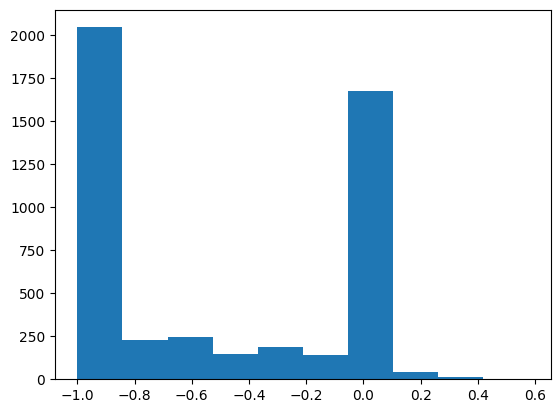

In [70]:
# # Check dataset

# plt.figure()
# plt.hist(align_data.sel(key="leading_ratio(F)"))
# plt.show()


In [20]:
## Save
with open("./data/align_data.pkl", "wb") as fp:
    pkl.dump(align_data, fp)

In [21]:
align_data["row_labels"]

['$\\chi(T)$',
 '$\\sigma[\\chi(T)]$',
 '$\\chi(F)$',
 '$\\sigma[\\chi(F)]$',
 '$\\chi(S)$',
 '$\\sigma[\\chi(S)]$',
 '$cv(T)$',
 '$\\sigma[cv(T)]$',
 '$cv(F)$',
 '$\\sigma[cv(F)]$',
 '$cv(S)$',
 '$\\sigma[cv(S)]$',
 '$z(T)$',
 '$\\sigma[z(T)]$',
 '$z(F)$',
 '$\\sigma[z(F)]$',
 '$z(S)$',
 '$\\sigma[z(S)]$',
 '$A_{large}(T)$',
 '$\\sigma[A_{large}(T)]$',
 '$A_{large}(F)$',
 '$\\sigma[A_{large}(F)]$',
 '$A_{large}(S)$',
 '$\\sigma[A_{large}(S)]$',
 '$\\tau_{large}(T)$',
 '$\\sigma[\\tau_{large}(T)]$',
 '$\\tau_{large}(F)$',
 '$\\sigma[\\tau_{large}(F)]$',
 '$\\tau_{large}(S)$',
 '$\\sigma[\\tau_{large}(S)]$',
 '$A_1(T)$',
 '$\\sigma[A_1(T)]$',
 '$A_1(F)$',
 '$\\sigma[A_1(F)]$',
 '$A_1(S)$',
 '$\\sigma[A_1(S)]$',
 '$\\tau_{1}(T)$',
 '$\\sigma[\\tau_{1}(T)]$',
 '$\\tau_{1}(F)$',
 '$\\sigma[\\tau_{1}(F)]$',
 '$\\tau_{1}(S)$',
 '$\\sigma[\\tau_{1}(S)]$',
 '$C(S)$',
 '$\\sigma[C(S)]$',
 '$\\tau_{cc}(S)$',
 '$\\sigma[\\tau_{cc}(S)]$',
 '$\\eta(F)$',
 '$|\\eta|(F)$',
 '$\\Delta \\phi(S)$',
 '$\